# Airbnbing in Florence

The scope of this project is to understand how much AirBNB homes are earning in certain time frames and areas, in the City of Florence, Tuscany. The project follows the guidelines CRISP-DM.

We want to investigate how we could invest capital into a flat of small-to-medium size (studio to 2 bedrooms) to rent for turists. To do so, we want to try to answer the following points:
  * Understand how airbnb businesses generally go in Florence in relation to our business goal. Listings are of any types, whereas we are interested in exploring small-to-medium-sized flats.
  * Which areas of Florence are more popular, bringing highest occupancy. Also, which listings are more consolidated per area, and which are the areas where new listings are appearing
  * Investigate the caracteristics of flats in relation to returns (how many guests can accept, utilities etc.) for the consolidated activities
  * How earnings are distributed along the year, causing fluctuation of returns

In [1]:
import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 881D-75E1

 Directory of C:\dev\airbnb_florence

11-Aug-19  12:26 PM    <DIR>          .
11-Aug-19  12:26 PM    <DIR>          ..
10-Aug-19  08:01 PM    <DIR>          .gitignore
11-Aug-19  11:44 AM    <DIR>          .ipynb_checkpoints
11-Aug-19  11:22 AM    <DIR>          data
11-Aug-19  12:26 PM            86,207 florence_listings.ipynb
10-Aug-19  08:28 PM             1,162 README.md
               2 File(s)         87,369 bytes
               5 Dir(s)   9,293,893,632 bytes free


In [3]:
PATH = os.getcwd()
fn_listings = os.path.join(PATH, 'data', 'listings_short.csv')
fn_districts = os.path.join(PATH, 'data', 'neighbourhoods.geojson')

In [4]:
df_lst = pd.read_csv(fn_listings)
df_dst = gpd.read_file(fn_districts)

In [5]:
df_dst

,neighbourhood,neighbourhood_group,geometry
0,Rifredi,None,"(POLYGON ((11.15421 43.786381, 11.153517 43.78..."
1,Gavinana Galluzzo,None,"(POLYGON ((11.231188 43.759284, 11.23121 43.75..."
2,Campo di Marte,None,"(POLYGON ((11.270991 43.764896, 11.271159 43.7..."
3,Isolotto Legnaia,None,"(POLYGON ((11.20787 43.749145, 11.207715 43.74..."
4,Centro Storico,None,"(POLYGON ((11.231188 43.759284, 11.231573 43.7..."


In [6]:
# listings. name and host_name are  reduntant as indxing can be done per id and host_id.
df_lst.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,24469,Fortezza/City Centre Modern Apt 2+2,99178,Benedetta And Lorenzo,NaN,Centro Storico,43.78308,11.24418,Entire home/apt,80,2,0,NaN,NaN,5,345
1,24470,Fortezza/City Centre Modern Apt 2+1,99178,Benedetta And Lorenzo,NaN,Centro Storico,43.78287,11.24431,Entire home/apt,75,2,3,2019-04-21,0.03,5,350
2,24471,Fortezza/City Centre Modern Apt 4+2,99178,Benedetta And Lorenzo,NaN,Centro Storico,43.78292,11.24460,Entire home/apt,135,2,0,NaN,NaN,5,355
3,24472,Fortezza/City Centre Modern Apt 4+2,99178,Benedetta And Lorenzo,NaN,Centro Storico,43.78150,11.24507,Entire home/apt,120,2,2,2012-04-11,0.02,5,342
4,24807,Beautiful Apartment Florence & WIFI,68490,Alberto,NaN,Campo di Marte,43.77813,11.29202,Entire home/apt,51,2,344,2019-05-21,3.10,1,152


### General stats

In [7]:
# let's see the stats.
# neighbourhood_group is all nan, as there is no grouping for Florence. Also look like some prices are at 0.
df_lst.describe()

,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,1.202200e+04,1.202200e+04,0.0,12022.000000,12022.000000,12022.000000,12022.000000,12022.000000,10349.000000,12022.000000,12022.000000
mean,1.799306e+07,6.589200e+07,NaN,43.773871,11.253617,102.435368,2.977791,48.030611,2.049765,14.003161,200.680087
std,1.085978e+07,7.523406e+07,NaN,0.009772,0.016564,122.866411,18.527526,74.106464,1.956661,33.441818,122.536516
min,2.446900e+04,1.565100e+04,NaN,43.726130,11.159010,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,7.795951e+06,7.147408e+06,NaN,43.768540,11.245380,55.000000,1.000000,2.000000,0.470000,1.000000,86.000000
50%,1.868842e+07,3.077204e+07,NaN,43.772285,11.254120,79.000000,2.000000,15.000000,1.440000,3.000000,226.500000
75%,2.702809e+07,1.083819e+08,NaN,43.778060,11.261977,110.000000,3.000000,62.000000,3.110000,7.000000,314.000000
max,3.594108e+07,2.702475e+08,NaN,43.831740,11.331010,5000.000000,1120.000000,719.000000,14.640000,176.000000,365.000000


Prices looks very broad. Let's explore prices set to zeros and prices which suggest exclusive accomodations.

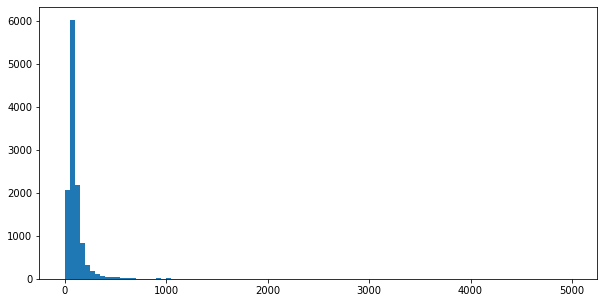

In [8]:
fig = plt.figure(figsize=(10,5))
plt.hist(df_lst['price'],bins=100);

In [9]:
# only two records have price == 0
df_lst[df_lst['price'] == 0]['id'].count()

2

also a maximum price of 5000 per night seems pretty out-of-the-standard. As we are interested of purchasing a flat of medium size, Let's see how many items are above 500€ per night

In [10]:
df_lst[df_lst['price'] > 500]['id'].count()

101

Let's remove from the df_lst the records with price per night of 0, and  and dropping unecessary columns. We want also to exclude particularly expensive flats because they are out of our business scope.

In [11]:
df_lst_ = df_lst.drop(columns=['name','host_name','neighbourhood_group'], axis=1)[df_lst['price'] != 0]
df_lst_ = df_lst_[df_lst['price'] <= 500]
df_lst_.head()

C:\Users\Claudio\AppData\Local\conda\conda\envs\airbnb_florence\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,24469,99178,Centro Storico,43.78308,11.24418,Entire home/apt,80,2,0,NaN,NaN,5,345
1,24470,99178,Centro Storico,43.78287,11.24431,Entire home/apt,75,2,3,2019-04-21,0.03,5,350
2,24471,99178,Centro Storico,43.78292,11.24460,Entire home/apt,135,2,0,NaN,NaN,5,355
3,24472,99178,Centro Storico,43.78150,11.24507,Entire home/apt,120,2,2,2012-04-11,0.02,5,342
4,24807,68490,Campo di Marte,43.77813,11.29202,Entire home/apt,51,2,344,2019-05-21,3.10,1,152


In [12]:
df_lst_.shape

(11919, 13)

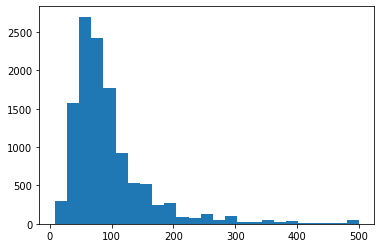

In [13]:
plt.hist(df_lst_['price'],bins=25);

### Listing Types

The `room_type` feature suggests that some hosts rent the place where they live, or might turn a property into a bnb-like business. The first case does not interest our research, whereas the latter poses serious problems in understanding how different rooms are part of the same flat (they would belong to the same host, but this might be a strong assumption to make).

In [14]:
# types of listing
df_lst_.groupby('room_type')['id'].nunique()

room_type
Entire home/apt    9239
Private room       2623
Shared room          57
Name: id, dtype: int64

In [16]:
one_shared_room = df_lst_[df_lst_['room_type']=='Private room'].groupby('host_id').count()==1
l = df_lst_.groupby('room_type')['id'].nunique()['Private room']
print('The provate rooms which are the only listing advertised by an host are the', 
      round((float(one_shared_room['id'].count())/l),4)*100,
      '%'
     )

The provate rooms which are the only listing advertised by an host are the 55.13 %


We can keep exploring the dataset keeping only `Entire home/apt`, which is more likely to answer our question

In [17]:
df_lst_ = df_lst_[df_lst_['room_type']=='Entire home/apt']
df_lst_.head()

,id,host_id,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,24469,99178,Centro Storico,43.78308,11.24418,Entire home/apt,80,2,0,NaN,NaN,5,345
1,24470,99178,Centro Storico,43.78287,11.24431,Entire home/apt,75,2,3,2019-04-21,0.03,5,350
2,24471,99178,Centro Storico,43.78292,11.24460,Entire home/apt,135,2,0,NaN,NaN,5,355
3,24472,99178,Centro Storico,43.78150,11.24507,Entire home/apt,120,2,2,2012-04-11,0.02,5,342
4,24807,68490,Campo di Marte,43.77813,11.29202,Entire home/apt,51,2,344,2019-05-21,3.10,1,152


In [18]:
df_lst_.shape

(9239, 13)

### Areas

Which areas of Florence are more popular, bringing highest occupancy. 
Also, can we assume that listing showing more reviews indicates more consolidated businesses? Where are these and which are the areas where listings with low number of reviews are concentrated?

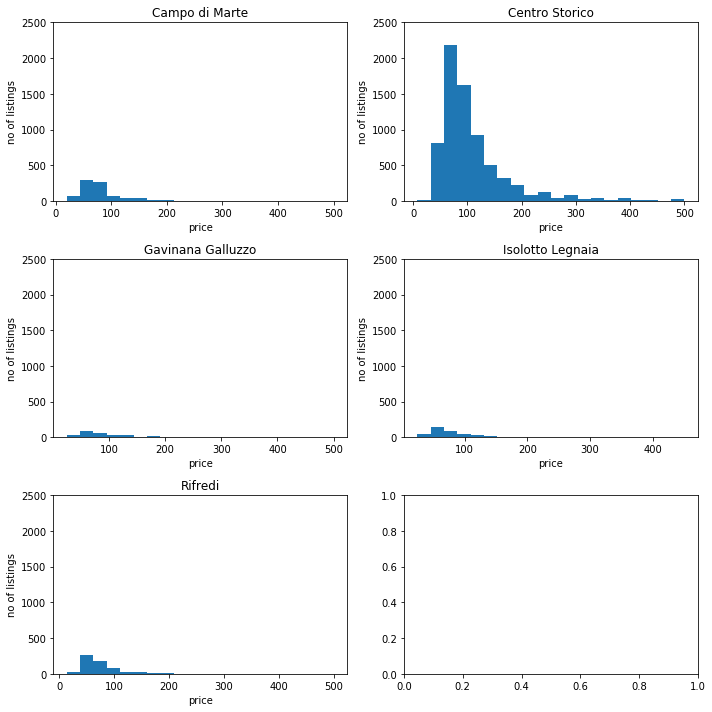

In [30]:
nb_gs = df_lst_.groupby('neighbourhood')

fig,axs = plt.subplots(3,2,figsize=(10,10))

for i,(n,g) in enumerate(nb_gs):
    ax = axs[i//2][i%2]
    ax.hist(g['price'], bins=20)
#     ax.hist(g['price'], bins=20, density=True)
    ax.set_xlabel('price')
    ax.set_ylabel('no of listings')
    ax.set_ylim((0,2500))
    ax.title.set_text(n)

plt.tight_layout()
plt.show()